# Harvest summary data from Trove lists

Using the Trove API we'll harvest some information about Trove lists and create a dataset containing the following fields:

* `id` — the list identifier, you can use this to get more information about a list from either the web interface or the API
* `title`
* `number_items` — the number of items in the list
* `created` — the date the list was created
* `updated` — the date the list was last updated

<div class="alert alert-block alert-warning">
<p>If you haven't used one of these notebooks before, they're basically web pages in which you can write, edit, and run live code. They're meant to encourage experimentation, so don't feel nervous. Just try running a few cells and see what happens!.</p>

<p>
    Some tips:
    <ul>
        <li>Code cells have boxes around them. When you hover over them a <i class="fa-step-forward fa"></i> icon appears.</li>
        <li>To run a code cell either click the <i class="fa-step-forward fa"></i> icon, or click on the cell and then hit <b>Shift+Enter</b>. The <b>Shift+Enter</b> combo will also move you to the next cell, so it's a quick way to work through the notebook.</li>
        <li>While a cell is running a <b>*</b> appears in the square brackets next to the cell. Once the cell has finished running the asterix will be replaced with a number.</li>
        <li>In most cases you'll want to start from the top of notebook and work your way down running each cell in turn. Later cells might depend on the results of earlier ones.</li>
        <li>To edit a code cell, just click on it and type stuff. Remember to run the cell once you've finished editing.</li>
    </ul>
</p>
</div>

## Setting up...

In [79]:
import requests
import pandas as pd
from tqdm import tqdm
import altair as alt
import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob
from operator import itemgetter
import nltk
from IPython.display import display, HTML
alt.renderers.enable('notebook')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/tim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Add your Trove API key

In [81]:
# This creates a variable called 'api_key', paste your key between the quotes
# <-- Then click the run icon 
api_key = ''

# This displays a message with your key
print('Your API key is: {}'.format(api_key))

Your API key is: 


## Set some parameters

You could change the value of `q` if you only want to harvest a subset of lists.

In [49]:
api_url = 'http://api.trove.nla.gov.au/v2/result'
params = {
    'q': ' ',
    'zone': 'list',
    'encoding': 'json',
    'n': 100,
    's': '*',
    'key': api_key,
    'reclevel': 'full'
}

## Harvest the data

In [50]:
def get_total():
    '''
    This will enable us to make a nice progress bar...
    '''
    response = requests.get(api_url, params=params)
    data = response.json()
    return int(data['response']['zone'][0]['records']['total'])

In [51]:
lists = []
total = get_total()
with tqdm(total=total) as pbar:
    while params['s']:
        response = requests.get(api_url, params=params)
        data = response.json()
        records = data['response']['zone'][0]['records']
        try:
            params['s'] = records['nextStart']
        except KeyError:
            params['s'] = None
        for record in records['list']:
            lists.append({
                'id': record['id'], 
                'title': record['title'], 
                'number_items': record['listItemCount'], 
                'created': record['created'],
                'updated': record['lastupdated']
            })
        pbar.update(100)

79300it [06:37, 194.81it/s]                           


## Inspect the results

In [36]:
df = pd.DataFrame(lists)
df.head()

,created,id,number_items,title,updated
0,2011-05-19T14:19:51Z,10000,52,Smith,2011-05-19T14:19:51Z
1,2017-03-01T08:07:33Z,100000,11,O'Grady,2017-03-01T08:07:33Z
2,2017-03-01T20:01:13Z,100003,127,Berry Street Victoria,2017-03-01T20:01:13Z
3,2017-03-01T21:27:56Z,100004,8,Angus Stuart Duff (WW1 Soldier),2017-03-01T21:27:56Z
4,2017-03-01T23:08:21Z,100006,7,H.U.D.U.F.S,2017-03-01T23:08:21Z


In [52]:
df.describe()

,number_items
count,79294.000000
mean,18.469708
std,70.437640
min,0.000000
25%,1.000000
50%,4.000000
75%,12.000000
max,5772.000000


## Save the harvested data as a CSV file

In [83]:
csv_file = 'data/trove-lists-{}.csv'.format(datetime.datetime.now().isoformat()[:10])
df.to_csv(csv_file, index=False)
display(HTML('<a target="_blank" href="{}">Download CSV</a>'.format(csv_file)))

## How many items are in lists?

In [39]:
total_items = df['number_items'].sum()
print('There are {:,} items in {:,} lists.'.format(total_items, len(lists)))

There are 1,464,537 items in 79,294 lists.


## What is the biggest list?

In [46]:
biggest = df.iloc[df['number_items'].idxmax()]
biggest

created              2015-04-03T11:50:51Z
id                                  71461
number_items                         5772
title           Victoria and elsewhere...
updated              2015-04-03T11:50:51Z
Name: 58137, dtype: object

In [48]:
display(HTML('The biggest list is <a target="_blank" href="https://trove.nla.gov.au/list?id={}">{}</a> with {:,} items.'.format(biggest['id'], biggest['title'], biggest['number_items'])))

## When were they created?

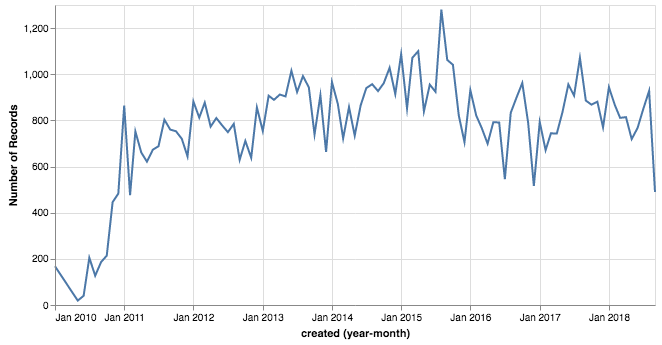

In [63]:
# This makes it possible to include more than 5000 records
alt.data_transformers.enable('json')
alt.Chart(df).mark_line().encode(
    x='yearmonth(created):T',
    y='count()',
    tooltip=[alt.Tooltip('yearmonth(created):T', title='Month'), alt.Tooltip('count()', title='Lists')]
).properties(width=600)

## What words are used in the titles?

In [64]:
titles = df['title'].str.lower().str.cat(sep=' ')

(-0.5, 1199.5, 799.5, -0.5)

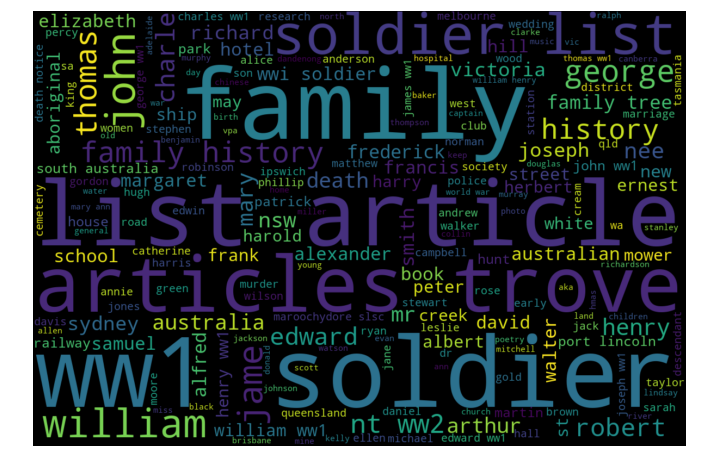

In [66]:
# Generate a word cloud image
wordcloud = WordCloud(width=1200, height=800).generate(titles)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [70]:
blob = TextBlob(titles)
stopwords = nltk.corpus.stopwords.words('english')
word_counts = [[word, count] for word, count in blob.lower().word_counts.items() if word not in stopwords]
word_counts = sorted(word_counts, key=itemgetter(1), reverse=True)[:25]
pd.DataFrame(word_counts).style.format({1: '{:,}'}).bar(subset=[1], color='#d65f5f').set_properties(subset=[1], **{'width': '300px'})

,0,1
0,family,"5,759"
1,soldier,"4,265"
2,ww1,"4,150"
3,articles,"4,136"
4,list,"4,128"
5,trove,"3,902"
6,john,"2,174"
7,william,"2,149"
8,history,"1,754"
9,james,"1,460"


In [74]:
ngrams = [' '.join(ngram).lower() for ngram in blob.lower().ngrams(2)]
ngram_counts = pd.DataFrame(ngrams)[0].value_counts().rename_axis('ngram').reset_index(name='count')
display(ngram_counts[:25].style.format({'count': '{:,}'}).bar(subset=['count'], color='#d65f5f').set_properties(subset=['count'], **{'width': '300px'}))

,ngram,count
0,ww1 soldier,"3,935"
1,list of,"3,863"
2,of articles,"3,838"
3,soldier list,"3,826"
4,in trove,"3,734"
5,articles in,"3,716"
6,family history,845
7,nt ww2,722
8,family tree,330
9,wwi soldier,271


In [75]:
ngrams = [' '.join(ngram).lower() for ngram in blob.lower().ngrams(3)]
ngram_counts = pd.DataFrame(ngrams)[0].value_counts().rename_axis('ngram').reset_index(name='count')
display(ngram_counts[:25].style.format({'count': '{:,}'}).bar(subset=['count'], color='#d65f5f').set_properties(subset=['count'], **{'width': '300px'}))

,ngram,count
0,list of articles,"3,827"
1,soldier list of,"3,819"
2,articles in trove,"3,708"
3,of articles in,"3,701"
4,ww1 soldier list,"3,542"
5,wwi soldier list,266
6,william ww1 soldier,219
7,henry ww1 soldier,191
8,john ww1 soldier,179
9,james ww1 soldier,159
